In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [5]:
import torch

In [6]:
torch.manual_seed(1)

In [7]:
import os
import sys

In [8]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes


In [9]:
sys.path

['',
 '/home/manifold/Documents/etudes/map511-p3a',
 '/home/manifold/miniconda3/envs/pytorch/lib/python37.zip',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.3.1-py3.7-linux-x86_64.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions',
 '/home/manifold/.ipython',
 '/home/manifold/Documents/etudes']

# Synthetic data, Hawkes processes

The standard Hawkes model has an underlying intensity given by
$$
    \lambda_t = \lambda^0_t + \int_0^t g(t-s)\,dN_s
$$
where the function $g \geq 0$ is called the _kernel_.

Here we simulate Hawkes processes with kernel $g(t) = \alpha\exp(-\delta t)$.

In [10]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [11]:
import itertools
mu = 1.0
tmax = 10.0
alpha = 0.4
beta  = 1.5

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 16.667


In [325]:
n_traj = 400
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

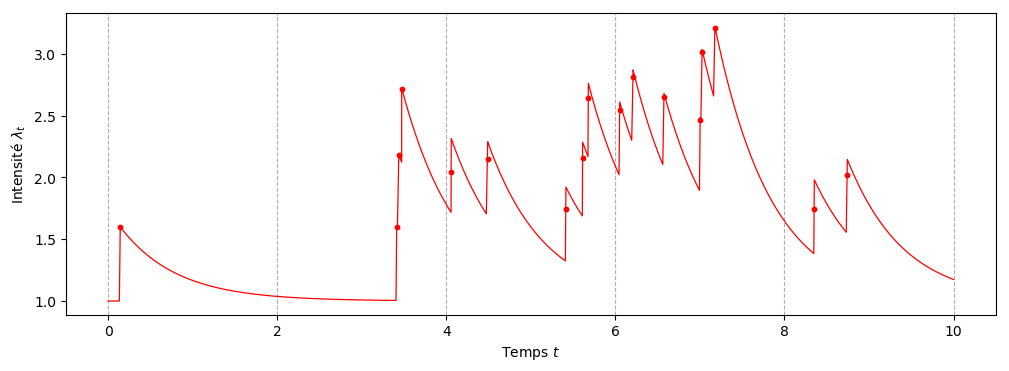

In [326]:
one_traj = sample_trajectories[100]
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [327]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])+1
input_size = seq_lengths.max().item()
var_sequences = [torch.from_numpy(s[:,0]) for s in sample_trajectories]
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)

Number of samples: 		400
Input size max. traj. length: 	36
tmax = 10.000


In [328]:
data_tensor = nn.utils.rnn.pad_sequence(var_sequences).to(torch.float)
# Add a beginning-of-sequence event:
data_tensor = torch.cat((torch.zeros(1,data_tensor.shape[1]), data_tensor), dim=0)

Text(0, 0.5, 'Number')

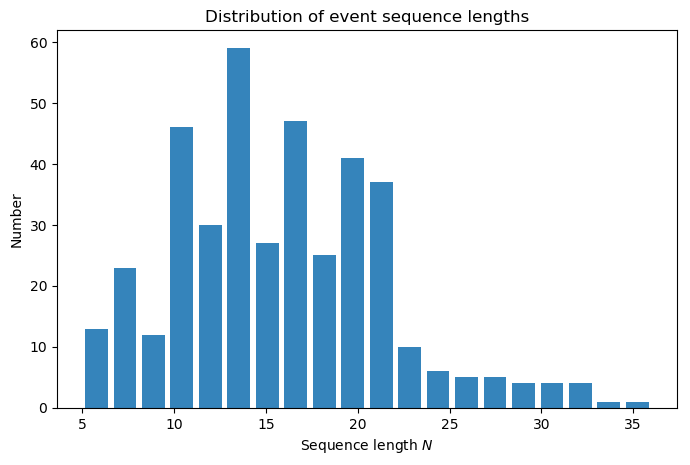

In [329]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(2/5)), rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [330]:
data_tensor.shape

torch.Size([36, 400])

The first dimension is for the sequence length, the second for the sample number.

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = \phi\left(W_h h(t)\right)
$$
with $\phi$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i-1}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

The initial values $(h_i)$ are learned recursively by the network.

In [389]:
from torch import nn
import torch.nn.functional as F

In [390]:
from models.rnn import HawkesRNNModel

In [391]:
hidden_size = 24
model = HawkesRNNModel(hidden_size)

In [392]:
data_tensor[:seq_lengths[10], 10]

tensor([0.0000, 0.4666, 0.6325, 0.7096, 1.6034, 1.8889, 2.1125, 2.1937, 3.1928,
        3.3810, 3.4490, 4.0392, 4.2641, 4.8926, 5.3165, 5.4213, 6.5654, 9.0157,
        9.4416, 9.9506])

In [393]:
sequence = data_tensor[:,10]

In [394]:
optimizer = torch.optim.Adam(model.parameters())

In [395]:
def train(model: HawkesRNNModel, sequence: torch.Tensor, seq_length):
    """
    Args:
        seq_length: sequence length
    """
    # Trim the sequence to its real length
    sequence = sequence[:seq_length]
    # Reshape to a format the RNN can understand
    # N * batch * 1 (= feature dim)
    sequence = sequence.unsqueeze(1).unsqueeze(1)
    dt_sequence = sequence[1:] - sequence[:-1]
    # Data records
    hidd = model.initialize_hidden()
    hiddens = []
    decays = []
    for i in range(seq_length-1):
        hidd, dec = model(dt_sequence[i], hidd)
        hiddens.append(hidd)
        decays.append(dec)
    hiddens = torch.stack(hiddens)
    decays = torch.stack(decays)
    train_data = {
        "hidden": hiddens,
        "decay": decays
    }
    loss: Tensor = model.compute_loss(sequence, hiddens, decays, tmax)
    loss.backward()
    optimizer.step()
    return train_data, loss.item()

In [396]:
sequence.unsqueeze(1).unsqueeze(1).shape

torch.Size([36, 1, 1])

In [397]:
# define training loop
train_size = 100
epochs = 20
loss_hist = []
for e in range(1, epochs+1):
    print("Epoch %d" % e)
    for i in range(train_size):
        optimizer.zero_grad()
        sequence = data_tensor[:, i]
        train_info, loss = train(model, sequence, seq_lengths[i])
    loss_hist.append(loss)  # append the final loss of each epoch

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


Text(0, 0.5, 'Loss')

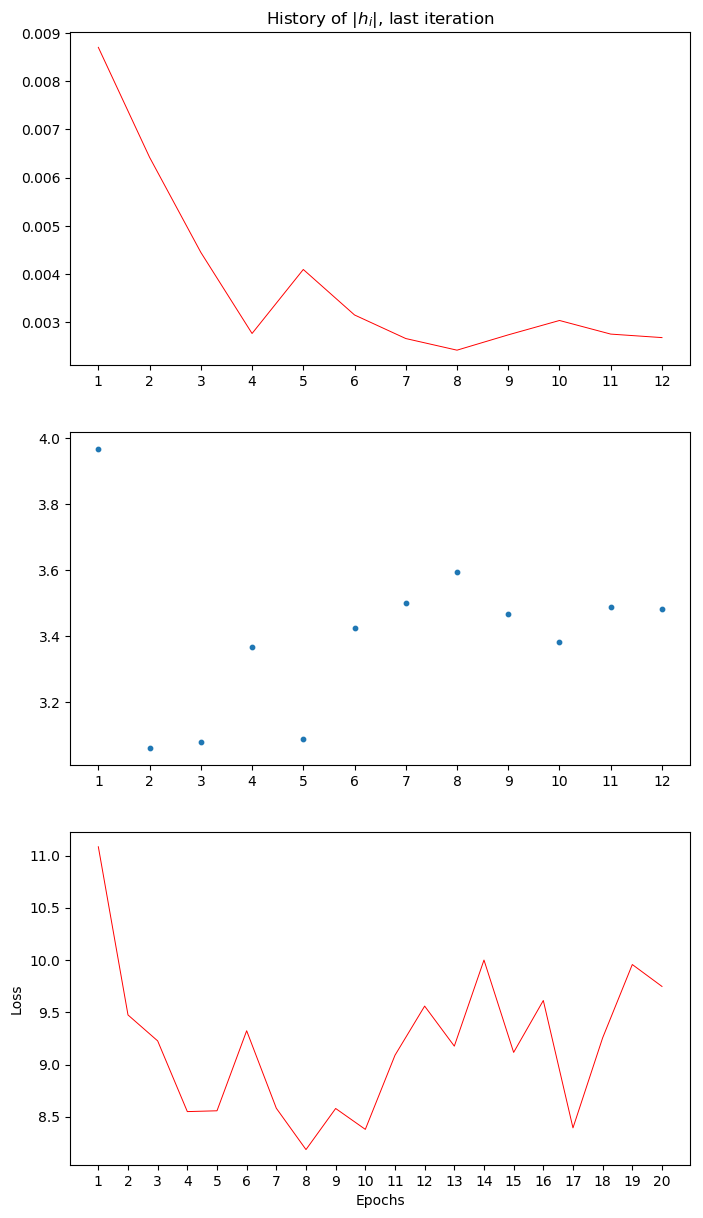

In [398]:
hidden_hist = train_info['hidden'].squeeze(1).squeeze(1)
decay_hist = train_info['decay'].squeeze(1).squeeze(1)
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(8,15), dpi=100)
seq_index_range = list(range(1, 1+len(hidden_hist)))
ax0.plot(seq_index_range, decay_hist.detach().numpy(), linewidth=.7, color='red')
ax0.set_title("History of $|h_i|$, last iteration")
ax0.set_xticks(seq_index_range)
ax1.scatter(seq_index_range, hidden_hist.detach().norm(dim=1).numpy(), s=10)
ax1.set_xticks(seq_index_range)
epochs_range = list(range(1, epochs+1))
ax2.plot(epochs_range, loss_hist, color='red', linewidth=.7)
ax2.set_xticks(epochs_range)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

In [518]:
gen_event_times, gen_event_intens = model.generate_sequence(tmax)
print(gen_event_times)

print("generated %d events" % len(gen_event_times))

[tensor([0.]), tensor([[0.0875]]), tensor([[0.5282]]), tensor([[0.6069]]), tensor([[1.5353]]), tensor([[2.6097]]), tensor([[2.8813]]), tensor([[3.1925]]), tensor([[3.7700]]), tensor([[4.1545]]), tensor([[4.2701]]), tensor([[7.6966]]), tensor([[9.1481]]), tensor([[9.7481]])]
generated 14 events
